# Building a Custom Task

This notebook walks through the general workflow of building a custom task using python classes. We'll also demonstrate how to deploy your custom task to DataRobot and integrate it into an existing blueprint!

## Note
The later sections of this tutorial require that you have access to Cloud DataRobot (app.datarobot.com or app.eu.datarobot.com)

## Agenda
In this tutorial, we'll learn:
1. How to create a custom task using simple python classes
2. How to test your python class
3. How to use the drum cli tools to test out your custom task 
4. How to use the DataRobot API to deploy your custom task to the DataRobot cloud for use in projects
5. How to insert a custom task on the DataRobot cloud into a blueprint

## Setup and Requirements

1. Ensure you have the DataRobot datarobot-user-models (DRUM) downloaded: https://github.com/datarobot/datarobot-user-models
2. Navigate to the drum repo, create a new virtual environment, and pip install -r requirements.txt from that repo
3. Follow the installation guide here for the blueprint workshop: https://blueprint-workshop.datarobot.com/setup.html 

Note: all filepaths are relative to the top level directory of the datarobot-user-models above. If you are in the correct directory you should see folders 
like task_templates, public_dropin_environments, tests, etc. 


## Configuring Models and Environments
For more information on how to properly configure custom tasks and environments, read the README of our [DataRobot User Models repository](https://github.com/datarobot/datarobot-user-models).

# Building a custom task

First, we need to import a few things

In [196]:
from pathlib import Path
import pandas as pd
import tensorflow as tf
import pickle

import keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.pipeline import Pipeline


Now let's build a neural network! First we'll lay out the code, then we'll walk through it

In [197]:
from datarobot_drum.custom_task_interfaces import RegressionEstimatorInterface

class CustomTask(RegressionEstimatorInterface):
    
    def fit(self, X, y, row_weights=None, **kwargs):
        tf.random.set_seed(1234)
        input_dim, output_dim = len(X.columns), 1

        model = Sequential(
            [
                Dense(
                    input_dim, activation="relu", input_dim=input_dim, kernel_initializer="normal"
                ),
                Dense(input_dim // 2, activation="relu", kernel_initializer="normal"),
                Dense(output_dim, kernel_initializer="normal"),
            ]
        )
        model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])

        callback = EarlyStopping(monitor="loss", patience=3)
        model.fit(
            X, y, epochs=20, batch_size=8, validation_split=0.33, verbose=1, callbacks=[callback]
        )

        # Attach the model to our object for future use
        self.estimator = model
        return self

    
    def save(self, artifact_directory):

        # If your estimator is not pickle-able, you can serialize it using its native method,
        # i.e. in this case for keras we use model.save, and then set the estimator to none
        keras.models.save_model(self.estimator, Path(artifact_directory) / "model.h5")

        # Helper method to handle serializing, via pickle, the CustomTask class
        self.save_task(artifact_directory, exclude=["estimator"])

        return self


    @classmethod
    def load(cls, artifact_directory):
        
        # Helper method to load the serialized CustomTask class
        custom_task = cls.load_task(artifact_directory)
        custom_task.estimator = keras.models.load_model(Path(artifact_directory) / "model.h5")

        return custom_task
    

    def predict(self, X, **kwargs):
        # Note how the regression estimator only outputs one column, so no explicit column names are needed
        return pd.DataFrame(data=self.estimator.predict(X))



There's a lot above, but the key idea is that we have 4 hooks: fit, save, load, and predict. DataRobot will use these hooks automatically to run our custom task. As you can probably guess, these hooks run in a specific order: first we train (fit) a model, then we serialize it (see the section [below]), then we load (i.e. deserialize) it again, and finally we make predictions. 

One thing to note is that the above CustomTask is simply a python class, which means we can also add helper methods or have functions / classes in a helper file that we import. The more complex your CustomTask, the more it probably makes sense to import a separate helper file to keep things simple. See [here] for an example of directly using helper methods in the class and [here] for using a separate helper file. 

## Training our model with Fit

Now let's actually use the class above. Since this is an ordinary python class, all we need to do is build an object and we can test it out to ensure our methods work! First, let's grab a dataset and then separate out the target column

In [198]:
df = pd.read_csv("tests/testdata/juniors_3_year_stats_regression.csv")

y = df['Grade 2014']
X = df.drop(labels=['Grade 2014'], axis=1)

Now let's train our model!

In [199]:
task = CustomTask()

In [200]:
task = task.fit(X,y)

Epoch 1/20
124/124 [==============================] - 1s 2ms/step - loss: 243.6316 - mae: 11.2293 - mse: 243.6316 - val_loss: 127.8057 - val_mae: 7.8969 - val_mse: 127.8057
Epoch 2/20
124/124 [==============================] - 0s 2ms/step - loss: 119.6218 - mae: 7.3784 - mse: 119.6218 - val_loss: 126.4541 - val_mae: 7.1894 - val_mse: 126.4541
Epoch 3/20
124/124 [==============================] - 0s 2ms/step - loss: 119.6898 - mae: 7.4064 - mse: 119.6898 - val_loss: 131.0404 - val_mae: 6.7115 - val_mse: 131.0404
Epoch 4/20
124/124 [==============================] - 0s 1ms/step - loss: 118.2549 - mae: 7.2968 - mse: 118.2549 - val_loss: 126.3128 - val_mae: 8.0251 - val_mse: 126.3128
Epoch 5/20
124/124 [==============================] - 0s 1ms/step - loss: 118.4696 - mae: 7.3713 - mse: 118.4696 - val_loss: 124.3396 - val_mae: 7.1751 - val_mse: 124.3396
Epoch 6/20
124/124 [==============================] - 0s 1ms/step - loss: 119.1182 - mae: 7.2953 - mse: 119.1182 - val_loss: 129.7029 - val

## Saving and Loading our Custom Task

You may be wondering why we need to save our model only to immediately load it again to make predictions. The reason is that model training and prediction, also known as inference or scoring, are distinct tasks that may have very different resource requirements. As an extreme example, one of DataRobot's proprietary models is a genetic algorithm known as Eureqa. Training this model can take some time, as it iterates through mathematical transformations. However the output of this model is a simple mathematical equation, which can run almost instantly on very modest computational resources. So during training we want to allocate a high amount of compute, but while the model is making predictions, e.g. it is deployed and waiting to receive new data, we want a far lower amount of compute allocated.  

The way we achieve this is by using Docker containers, which we can think of as extremely lightweight virtual machines. This allows our training container to have significantly different computational resources allocated than our prediction container. But since the training and prediction steps are in separate containers, we need a way to move trained models and other useful artifacts, e.g. class labels, between them. The solution is to write out the artifacts to disk, i.e. serialize them. So our save method at the end of training will write out the model to a shared file storage location and then our load method at the beginning of making predictions will read the artifacts into memory, i.e. deserialize them. 


In [201]:
task.save(".")

In [202]:
task = task.load(".")

In [203]:
task.predict(X)

,0
0,27.046207
1,25.635019
2,26.916660
3,25.292889
4,28.178623
...,...
1472,24.894941
1473,26.109985
1474,31.427782
1475,23.208033


Let's take a look more deeply at the save method:

In [204]:
??task.save

Signature: task.save(artifact_directory)
Docstring:
Serializes the object and stores it in `artifact_directory`

Parameters
----------
artifact_directory: str
    Path to the directory to save the serialized artifact(s) to.

Returns
-------
self
Source:   
    def save(self, artifact_directory):

        # If your estimator is not pickle-able, you can serialize it using its native method,
        # i.e. in this case for keras we use model.save, and then set the estimator to none
        keras.models.save_model(self.estimator, Path(artifact_directory) / "model.h5")

        # Helper method to handle serializing, via pickle, the CustomTask class
        self.save_task(artifact_directory, exclude=["estimator"])

        return self
File:      /var/folders/zd/m7w2dbld2v9dlsdrtdrb1ms40000gq/T/ipykernel_58586/2228518297.py
Type:      method


As we can see, we use two distinct functions to save our model. First, we use the keras function save_model to save our self.estimator, i.e. the trained model from the fit function. Then we use a built in helper function, save_task. Let's look at save task quickly:



In [24]:
??task.save_task

Signature: task.save_task(artifact_directory, exclude=None)
Source:   
    def save_task(self, artifact_directory, exclude=None):
        """
        Helper function that abstracts away pickling the CustomTask object. It also can
        automatically set previously serialized variables to None, e.g. when using keras you likely
        want to serialize self.estimator using model.save() or keras.models.save_model() and then
        pass in exclude='estimator'

        Parameters
        ----------
        artifact_directory: str
            Path to the directory to save the serialized artifact(s) to.
        exclude: List[str]
            Variables on the CustomTask object we want to exclude from serialization by setting to None

        Returns
        -------
        None
        """
        # If any custom task variables are excluded in the pickle, temporarily store them here, set them to None, then
        # restore them back onto the class after serialization
        variables_to_

Don't worry about understanding every line above. The key point is that we set everything passed in the exclude parameter to None, then we use a the standard python library pickle to serialize the CustomTask object. The reason we do this is flexibility. There are a wide array of python ML frameworks, e.g. keras / tensorflow, pytorch, xgboost, etc. Many of these frameworks, particularly those around neural networks, have their own serialization functions that handle all the complexities around storing weights, archiectures, etc. 

So the recommended pattern is to save your estimator using your framework's serialization function, e.g. keras.models.save_model above, and then use the helper function save_task we provide to save the rest of your CustomTask object. 

If we look at the load method, we see that we simply reverse the order. First we use the helper function load_task to load our CustomTask object using pickle, then we load our estimator into self.estimator using the keras function load_model:

In [25]:
??task.load

Signature: task.load(artifact_directory)
Docstring:
Deserializes the object stored within `artifact_directory`.

Parameters
----------
artifact_directory: str
    Path to the directory to save the serialized artifact(s) to.

Returns
-------
cls
    The deserialized object
Source:   
    @classmethod
    def load(cls, artifact_directory):
        
        # Helper method to load the serialized CustomTask class
        custom_task = cls.load_task(artifact_directory)
        custom_task.estimator = keras.models.load_model(Path(artifact_directory) / "model.h5")

        return custom_task
File:      /var/folders/zd/m7w2dbld2v9dlsdrtdrb1ms40000gq/T/ipykernel_58586/2228518297.py
Type:      method


It's important to understand that some python ML frameworks, notably Sklearn, use pickle for their serialization as well. This means we don't need to write our own save / load functions in our CustomTask, as the default functions will simply pickle everyting including the model. The below example is from the template [here] and shows how this looks for a simple sklearn model. You can see that the whole CustomTask is around 10 lines of code. Pretty neat, huh?

In [27]:
class CustomTask(RegressionEstimatorInterface):
    def fit(self, X, y, row_weights=None, **kwargs):
        
        self.estimator = Ridge()
        self.estimator.fit(X, y)

        return self

    def predict(self, X, **kwargs):

        return pd.DataFrame(data=self.estimator.predict(X))



## Making Predictions with the Correct Output

A CustomTask currently has to output a pandas dataframe where the rows are the samples and the columns the predictions. 

As you may have noticed, all of examples so far have been regressors, i.e. outputting a single, numeric prediction. So our rows are just the number of samples and we have a single column (which doesn't need a specific name). We can see that our CustomTasks above inherit from the RegressionEstimatorInterface, which enforces this behavior.

We can use the exact same behavior when we are creating an anomaly detection CustomTask, because the output is again a single numeric column representing how anomalous each sample is. There is a corresponding AnomalyEstimatorInterface.


Things are a little trickier though when we need to create a binary or multiclass estimator. That's because we'll need to align the columns to the classes. Keep in mind that our CustomTask will run inside a DataRobot blueprint, which will be given a list of classes in the target. Let's take a look at an example binary estimator:

In [30]:
from datarobot_drum.custom_task_interfaces import BinaryEstimatorInterface

class CustomTask(BinaryEstimatorInterface):
    def fit(self, X, y, row_weights=None, **kwargs):
        
        self.estimator = DecisionTreeClassifier()
        self.estimator.fit(X, y)

        return self

    def predict_proba(self, X, **kwargs):

        # Note that binary estimators require two columns in the output, the positive and negative class labels
        # So we need to pass in the class names derived from the estimator as column names OR
        # we can use the class labels from DataRobot stored in
        # kwargs['positive_class_label'] and kwargs['negative_class_label']
        return pd.DataFrame(data=self.estimator.predict_proba(X), columns=self.estimator.classes_)

The first thing to notice is that because we're outputting probabilities, we define a predict_proba instead of a predict function. The second thing to notice is that we have to provide the column names of our dataframe, and they have to align to the classes of our dataset. If you look at the fit function, you'll notice we directly pass in the target column y. This will have our target labels and these will be passed to our model as we train it, i.e. self.estimator.fit()


For binary classification, DataRobot requires there to be 2 columns: the positive class prediction and the negative class prediction 
(which is the inverse). Obviously, these two numbers should sum up to 1.0. 

For frameworks that output 2 classes, like sklearn, we can simply use the classes stored by the sklearn model itself, i.e. self.estimator.classes_

Some frameworks, such as pytorch, instead only output one column (typically the positive class probability). In those cases we have to derive the negative class column, as seen below:

In [32]:
    def predict_proba(self, X, **kwargs):
        """Since pytorch only outputs a single probability, i.e. the probability of the positive class,
         we use the class labels passed in kwargs to label the columns"""
        data_tensor = torch.from_numpy(X.values).type(torch.FloatTensor)
        predictions = self.estimator(data_tensor).cpu().data.numpy()
        
        predictions = pd.DataFrame(predictions, columns=[kwargs["positive_class_label"]])

        # The negative class probability is just the inverse of what the model predicts above
        predictions[kwargs["negative_class_label"]] = (
            1 - predictions[kwargs["positive_class_label"]]
        )
        return predictions


Multiclass is slightly more challenging. Here we'll need to output the probability of each class as a separate column. If our framework stores. the classes, like many sklearn models, we can use the same exact same approach as above with binary classification. If the framework doesn't store the classes, e.g. pytorch, then we'll need to store the classes during the fit step on the self object so it can be used as the columns (Note: the save & load methods are excluded below to focus in on the unique aspects of multiclass):

In [35]:
from datarobot_drum.custom_task_interfaces import MulticlassEstimatorInterface


class CustomTask(MulticlassEstimatorInterface):
    def fit(self, X, y, row_weights=None, **kwargs):
        """Note how we encode the class labels and store them on self to be used in the predict hook"""
        self.lb = LabelEncoder().fit(y)
        y = self.lb.transform(y)

        # For reproducible results
        torch.manual_seed(0)

        self.estimator, optimizer, criterion = build_classifier(X, len(self.lb.classes_))
        train_classifier(X, y, self.estimator, optimizer, criterion)
        

    def predict_proba(self, X, **kwargs):
        """Note how the column names come from the encoded class labels in the fit hook above"""
        data_tensor = torch.from_numpy(X.values).type(torch.FloatTensor)
        predictions = self.estimator(data_tensor).cpu().data.numpy()

        # Note that multiclass estimators require one column per class in the output
        # So we need to pass in the class names derived from the estimator as column names.
        return pd.DataFrame(data=predictions, columns=self.lb.classes_)


## Transformers vs. Estimators

So far we've focused on Estimators, which output a prediction. We can also create transforms, which manipulate the data and pass it along to (eventually) an estimator. Note: this final estimator can either be a built in DataRobot task or a CustomTask.

The key difference between estimators and transforms is that instead of a predict function we have a transform function. The transform function also returns a dataframe, but instead of predictions it returns the transformed data. Note that while you can certainly create or remove columns, the transform function must output the same number of rows, e.g. you can't create new synthetic data.

It's important to keep in mind that the fit and transform functions also run in separate containers. So any artifacts need to be saved, either by using the default pickling functions that run automatically, or by defining your own save and load functions. 

Below is a simple example where you fill in missing values using median imputation. Note that because we are simply storing the imputation function as part of self, we can use the built in save and load functions so we don't have to define our own:

In [37]:
from datarobot_drum.custom_task_interfaces import TransformerInterface


class CustomTask(TransformerInterface):
    def fit(self, X, y, **kwargs):

        # Any information derived from the training data (i.e. median values for each column) should be stored to self.
        # Then, in the transform hook below, we use this information to transform any data that passes through this task
        self.medians = X.median(axis=0, numeric_only=True, skipna=True).to_dict()
        return self

    def transform(self, X, **kwargs):
        return X.fillna(self.medians)

One important thing to note is that we provide the target column as part of the fit function above so you can create target encoders or other related transforms. Since your CustomTask transform will run in a DataRobot blueprint, DataRobot will automatically handle setting up the defined partitioning strategy, e.g. 5 fold cross validation, and only run the fit function on the training folds. But it's always possible to introduce target leakage / overfitting with any encoding strategy, so please take care!


## Understanding the CustomTask Interface (Optional)

In the above sections, we mentioned that DataRobot automatically serialize your CustomTask as a pickle file unless you provided your own save / load functions. This is because we defined a series of interfaces that inherit from each other and have default implementations. Let's walk through them quickly.

The top level interface is the target type interfaces, e.g. TransformerInterface, MulticlassEstimatorInterface, etc. These provide the relevant predict functions. Each of these inherits from a CustomTaskInterface, which provides the default fit method. 

Finally, the top level function is. the Serializable interface. You can see that by default, the save and load functions simply call the save_task and load_task helper functions. This is to provide a level of abstraction. When you define your own CustomTask save or load function, you can use the save_task and load_task functions to avoid having to write your own code to pickle the CustomTask object. 

In [47]:
class Serializable(object):
    default_artifact_filename = "drum_artifact.pkl"

    def save(self, artifact_directory):

        self.save_task(artifact_directory)

        # For use in easy chaining, e.g. CustomTask().fit().save().load()
        return self

    def save_task(self, artifact_directory, exclude=None):
        """
        Helper function that abstracts away pickling the CustomTask object. It also can
        automatically set previously serialized variables to None, e.g. when using keras you likely
        want to serialize self.estimator using model.save() or keras.models.save_model() and then
        pass in exclude='estimator'

        Parameters
        ----------
        artifact_directory: str
            Path to the directory to save the serialized artifact(s) to.
        exclude: List[str]
            Variables on the CustomTask object we want to exclude from serialization by setting to None

        Returns
        -------
        None
        """
        # If any custom task variables are excluded in the pickle, temporarily store them here, set them to None, then
        # restore them back onto the class after serialization
        variables_to_restore = {}

        if exclude:
            for custom_task_variable in exclude:
                try:
                    # Ensure the variable actually exists in the custom task
                    variables_to_restore[custom_task_variable] = getattr(self, custom_task_variable)
                except AttributeError:
                    raise DrumCommonException(
                        f"The object named {custom_task_variable} passed in exclude= was not found"
                    )

                # Set it to None so it does not get serialized
                setattr(self, custom_task_variable, None)
        with open(
            os.path.join(artifact_directory, Serializable.default_artifact_filename), "wb"
        ) as fp:
            pickle.dump(self, fp)

        for custom_task_variable, value in variables_to_restore.items():
            setattr(self, custom_task_variable, value)

    @classmethod
    def load(cls, artifact_directory):

        return cls.load_task(artifact_directory)

    @classmethod
    def load_task(cls, artifact_directory):
        """
        Helper method to abstract deserializing the pickle object stored within `artifact_directory` and
        returning the custom task. Any variables that were excluded in `save_task` must be manually loaded
        proceeding this function.

        Parameters
        ----------
        artifact_directory: str
            Path to the directory to save the serialized artifact(s) to.

        Returns
        -------
        cls
            The deserialized object
        """
        with open(
            os.path.join(artifact_directory, Serializable.default_artifact_filename), "rb"
        ) as fp:
            deserialized_object = pickle.load(fp)

        if not isinstance(deserialized_object, cls):
            raise DrumCommonException(
                "load_task method must return a {} class".format(cls.__name__)
            )
        return deserialized_object

# Testing the Custom Task 

Because our CustomTask is simply a python class, we can utilize standard python testing libraries / frameworks. 

E.g. we can verify with a test dataset that our CustomTask matches the expected output

In [184]:
# Note: for this example we're simply checking the outputs against itself. But in reality this would be a list of previous predictions
previous_predictions = task.predict(X).values
assert all(task.predict(X).values == previous_predictions)

We can also make assertions about our output to ensure our predictions are in a sensible range

In [189]:
maximum_prediction = 50
assert task.predict(X).values.max() < maximum_prediction

These tests can easily be incorporated into a CI/CD pipeline and run automatically!

# How to upload a Custom Task via the web application

The easiest way to upload your custom task is to place all of your code into a file called custom.py. For practice, you can copy the code in the CustomTask above (the Keras regression estimator near the top) and place it in a custom.py. Note that [here] is a example of this exact Keras Regressor Custom Task with all the necessary files if you want to inspect it. 

The next step is to define a model-metadata.yaml. This tells DataRobot a bit about your custom task, e.g. if it's a binary or regression estimator, and also provides guardrails about what type of data it accepts as input and output. E.g. our Keras estimator above only handles numeric data and can't handle missing values. 

Finally, you may need to create a requirements.txt file. As mentioned above, your CustomTask is run in a Docker Container. DataRobot by default provides a series of drop in environments for each language / framework (see [here]). In the case of the Keras regression CustomTask above, we don't need to import anything outside what that environment contains. You can see an example of a CustomTask using a requirements.txt file [here]

Once you have all the files ready, you can follow instructions [here] to upload your CustomTask through the Model Registry -> Tasks page. Then you can follow instructions [here] to use your custom task in a DataRobot blueprint

# How to upload a Custom Task through the API

DataRobot supports a robust python, R, and REST API that you use to programatically control data prep, modeling, and deployments. The goal is to let you create an end to end model pipeline without ever having to leave your favorite IDE or notebook (although please at least look at our web application, it's pretty!) 

In the next few sections we'll show how to quickly create a project to use as an example. We'll then run a few of DataRobot's default blueprints so we can add our CustomTask to them. Then we'll upload the CustomTask we created above, visualize the existing blueprint, and finally add our custom blueprint to the task. 

Please keep in mind the focus here is on CustomTasks and not a general walkthrough of the API. For that, please see the excellent tutorials [here]

## Create and run a project

We'll be using the docs here if you'd like more information: https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.27.1/reference/modeling/project.html#create-a-project

In [54]:
import datarobot as dr

In [56]:
# Note, we can also use dr.Dataset.create_from_in_memory_data to create our dataset directly from the pandas dataframe above
dataset = dr.Dataset.create_from_file(file_path="tests/testdata/juniors_3_year_stats_regression.csv")

In [57]:
# Note: we could also have just used dr.Project.create to directly create the project. 
project = dr.Project.create_from_dataset(dataset.id, project_name="Keras Regression Custom Task Tutorial")

In [59]:
# This will start the modeling, note that it will run asynchronously 
target_name = "Grade 2014"
project.analyze_and_model(target=target_name,
                   worker_count=-1, # Max workers
                   mode=dr.AUTOPILOT_MODE.QUICK
                  )


Project(Keras Regression Custom Task Tutorial)

In [60]:
# This will let us know when autopilot is finished
project.wait_for_autopilot()

In progress: 2, queued: 10 (waited: 0s)
In progress: 2, queued: 10 (waited: 0s)
In progress: 2, queued: 10 (waited: 1s)
In progress: 2, queued: 10 (waited: 1s)
In progress: 2, queued: 10 (waited: 2s)
In progress: 2, queued: 10 (waited: 4s)
In progress: 1, queued: 9 (waited: 7s)
In progress: 4, queued: 6 (waited: 14s)
In progress: 4, queued: 1 (waited: 27s)
In progress: 0, queued: 0 (waited: 47s)
In progress: 4, queued: 1 (waited: 67s)
In progress: 1, queued: 0 (waited: 87s)
In progress: 0, queued: 0 (waited: 108s)
In progress: 1, queued: 0 (waited: 128s)
In progress: 1, queued: 0 (waited: 148s)
In progress: 1, queued: 0 (waited: 168s)
In progress: 1, queued: 0 (waited: 188s)
In progress: 0, queued: 0 (waited: 208s)
In progress: 0, queued: 0 (waited: 229s)


In [62]:
# We can now list the top 3 models that ran
models = project.get_models()
print(models[:3])

[Model('Keras Slim Residual Neural Network Regressor using Training Schedule (1 Layer: 64 Units)'), Model('Keras Slim Residual Neural Network Regressor using Training Schedule (1 Layer: 64 Units)'), Model('Ridge Regressor')]


## Upload our Custom Task

Now that we have a project with models to work with, let's upload our CustomTask! 
We'll be using the docs here: https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.27.1/reference/modeling/spec/custom_task.html

The first thing we'll need to do is ensure we have the appropriate execution environment for our CustomTask. You can find a list of these in the github [here].

In [65]:
execution_environment = dr.ExecutionEnvironment.create(
    name="Python3 Keras Environment",
    description="This environment contains Python3 keras library.",
)

In [66]:
# Note this may take a few minutes to build the Docker image
execution_environment_version = dr.ExecutionEnvironmentVersion.create(execution_environment.id, 
                                                                      "public_dropin_environments/python3_keras", 
                                                                      "First Version")

Now we can create a CustomTask and a CustomTaskVersion. We use versions because it's likely will iterate on our CustomTask, 
and DataRobot by default will use the default version

In [68]:
from datarobot.enums import CUSTOM_TASK_TARGET_TYPE

keras_regression = dr.CustomTask.create(
    name="keras custom task regressor",
    target_type=CUSTOM_TASK_TARGET_TYPE.REGRESSION
)

In [69]:
custom_task_folder = "tests/fixtures/custom_task_interface_keras_regression"

task_version = dr.CustomTaskVersion.create_clean(
    custom_task_id=keras_regression.id,
    base_environment_id=execution_environment.id,
    folder_path=custom_task_folder,
)

In [72]:
keras_regression.refresh() # We have to perform a GET request to update
keras_regression.latest_version

CustomTaskVersion('v1.0')

## Visualize an existing Blueprint

Now we'll use the blueprint workshop API: https://blueprint-workshop.datarobot.com/getting_started.html

Please make sure you've installed the appropriate dependencies, notably graphviz (see https://blueprint-workshop.datarobot.com/setup.html) 

The key point to remember is that DataRobot's Blueprints (BPs) are Directed Acyclic Graphs (DAGs). This means that data flows from left to right. Typically the data is split by data types and fed to different paths or branches that apply preprocessing. Our dataset only has numeric data, so that's all we see. 

Let's visualize an exisitng blueprint that was created by DataRobot's AutoML

In [78]:
from datarobot_bp_workshop import Workshop, Visualize
w = Workshop()

In [191]:
# One important note is that models and blueprints are separate. A blueprint trained on a dataset becomes a model

# This will default to getting the top model 
models = project.get_models()
top_model = models[5] # This is for convenience, you can choose any model you'd like
blueprint = dr.Blueprint.get(project.id, top_model.blueprint_id)


Note: if you're comparing to the DataRobot Web Application UI, make sure to click "Copy and Edit" otherwise you might see a different visual.
This is because the blueprint shown on the leaderboard automatically removes from the visualization any pathways that aren't used. In this case the leaderboard UI will show only the Numeric Variables path because our dataset only has numerics. But the same blueprint run on Numerics + Text data would show both pathways.

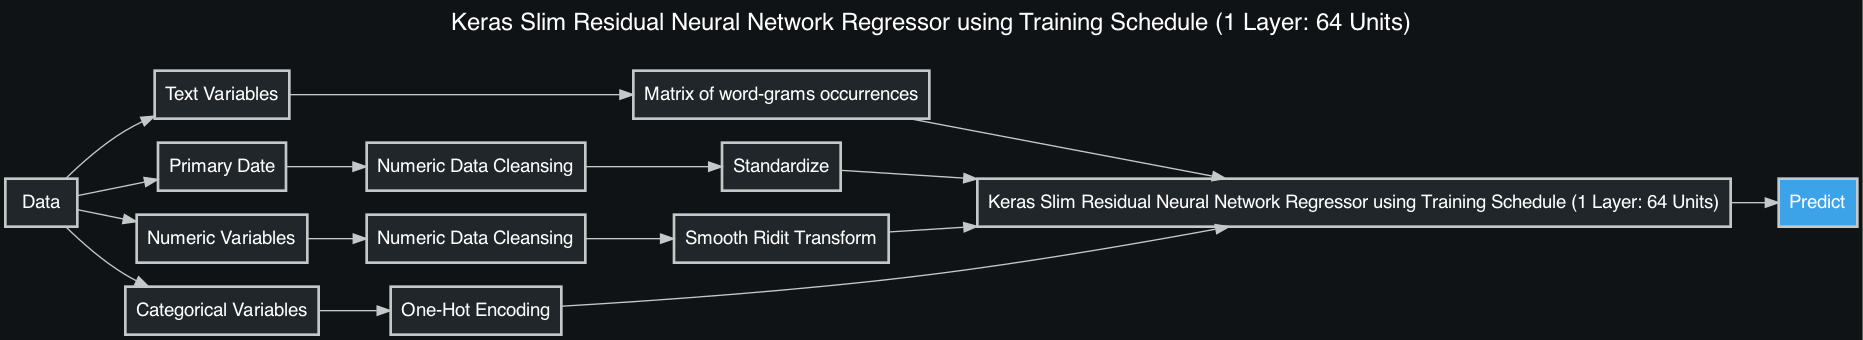

In [173]:
Visualize.show_dr_blueprint(blueprint) 

We can inspect any blueprint to understand what tasks it has. This will give us information if we want to create a brand new blueprint using our CustomTask or insert our CustomTask into an existing blueprint and then modify it further with DataRobot's tasks

In [130]:
blueprint_graph = w.clone(top_model.blueprint_id, project.id)
source_code = blueprint_graph.to_source_code(to_stdout=True)

w = Workshop(user_blueprint_id='6202e28f1255e7118a50d079')

pdm3 = w.Tasks.PDM3(w.TaskInputs.CAT)
pdm3.set_task_parameters(cm=50000, sc=10)

ndc = w.Tasks.NDC(w.TaskInputs.NUM)

rdt5 = w.Tasks.RDT5(ndc)

ptm3 = w.Tasks.PTM3(w.TaskInputs.TXT)
ptm3.set_task_parameters(d2=0.8, mxf=20000, d1=1, n='l1')

ndc_1 = w.Tasks.NDC(w.TaskInputs.DATE)

rst = w.Tasks.RST(ndc_1)
rst.set_task_parameters(spt=1)

kerasr = w.Tasks.KERASR(rdt5, rst, pdm3, ptm3)
kerasr.set_task_parameters(epochs=8, hidden_dropout=0.05, hidden_units='list(64)', learning_rate=0.03, use_training_schedule=1)

kerasr_blueprint = w.BlueprintGraph(kerasr, name='Keras Slim Residual Neural Network Regressor using Training Schedule (1 Layer: 64 Units)')


You can also easily list all the tasks, see https://blueprint-workshop.datarobot.com/examples/walkthrough/Walkthrough.html#Help-with-Tasks for more details

## Retrieve Custom Task

In [155]:
w.search_tasks("keras custom task regressor") # the name of our task above

keras custom task regressor: [CUSTOMR_6202d89c1255e7118a50d059] 
  - (No description)

## Add our CustomTask

Now that we have our top blueprint, let's replace the Keras Neural Network estimator with our own CustomTask! We can grab the source code from the blueprint above, but we'll replace the existing keras estimator with our custom task



In [192]:
# Copied from above
w = Workshop(user_blueprint_id='6202e28f1255e7118a50d079')

pdm3 = w.Tasks.PDM3(w.TaskInputs.CAT)
pdm3.set_task_parameters(cm=50000, sc=10)

ndc = w.Tasks.NDC(w.TaskInputs.NUM)

rdt5 = w.Tasks.RDT5(ndc)

ptm3 = w.Tasks.PTM3(w.TaskInputs.TXT)
ptm3.set_task_parameters(d2=0.8, mxf=20000, d1=1, n='l1')

ndc_1 = w.Tasks.NDC(w.TaskInputs.DATE)

rst = w.Tasks.RST(ndc_1)
rst.set_task_parameters(spt=1)

# This is the only difference, we replace the KERASR with our Custom Task
kerasr = w.CustomTasks.CUSTOMR_6202d89c1255e7118a50d059(rdt5, rst, pdm3, ptm3)

In [168]:
keras_custom_task_blueprint = w.BlueprintGraph(kerasr, name='Keras Custom Task')

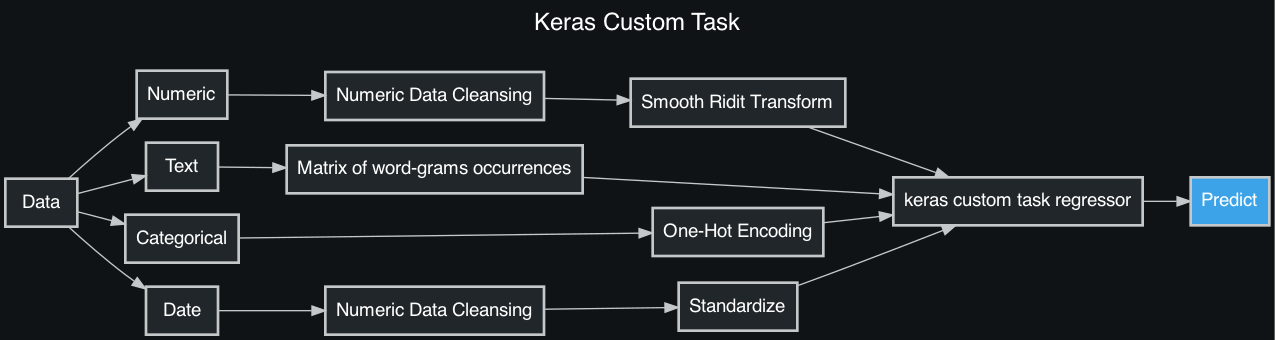

In [169]:
keras_custom_task_blueprint.show()

In [171]:
# Note this is asynchronous
keras_custom_task_blueprint.train(project_id=project.id)

Training requested! Blueprint Id: e30d8f9ec2290d95f65b97de4c78307e


Name: 'Keras Custom Task'

Input Data: Categorical | Numeric | Text | Date
Tasks: One-Hot Encoding | Numeric Data Cleansing | Smooth Ridit Transform | Matrix of word-grams occurrences | Standardize | keras custom task regressor

Congratulations! You've now successfully created a CustomTask, uploaded it to DataRobot, and inserted it into a Blueprint all within a Jupyter Notebook!